# Приоритизация и проверка гипотез для интернет-магазина
<h1>Цели и задачи</h1>
Приоритизировать и проверить гипотезы по увеличению выручки для интернет-магазина. В ходе проритизации гипотез будем использовать подходы ICE и RICE. Для анализа результата А/В теста определим кумулятивные средние выручки, конверсии, средние чеки по группам, аналогично по количеству и стоимостям заказов. о результатам теста определим либо превосходство одной группы, либо равенство двух групп, либо примем решение продолжить тест.   
<h1>Исходные данные</h1>
В качестве исходных данных для приоритизации гипотез предоставлен файл с 9 гипотезами по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
<br>Для проведения анализа А/В теста даны 2 файла, содержащие результаты теста отдельно по посетителям и по заказам.
<h2>Анализ и подготовка данных</h2>
Загрузим необходимые для выполнения работы библиотеки:

In [1]:
#библиотеки
import pandas as pd
from datetime import datetime,timedelta as dt
import scipy.stats as stats
from matplotlib import pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
import warnings

Прочитаем исходные файлы и выведем информацию по каждому из них

In [2]:
hypothesis=pd.read_csv('/datasets/hypothesis.csv')
orders=pd.read_csv('/datasets/orders.csv')
visitors=pd.read_csv('/datasets/visitors.csv')
display(hypothesis.info(),orders.info(),visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

None

None

None

Преобразуем названия столбцов в "змеиный" регистр и поменяем формат у столбцов, содержащих дату:

In [3]:
#датасет hypothesis
hypothesis = hypothesis.rename(
columns={
'Hypothesis': 'hypothesis',
'Reach': 'reach',
'Impact': 'impact',
'Confidence': 'confidence',
'Efforts': 'efforts',
}
)
display(hypothesis.head())

#датасет orders
orders = orders.rename(
columns={
'transactionId': 'transaction_id',
'visitorId': 'visitor_id',
}
)
orders['date'] = pd.to_datetime(orders['date'])
display(orders.head())

#датасет visitors
visitors['date'] = pd.to_datetime(visitors['date'])
display(visitors.head())

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<h3>Проверка явных и неявных дубликатов</h3>
Уберем явные дубликаты по каждому датафрейму

In [4]:
print(hypothesis.duplicated().sum())
hypothesis = hypothesis.drop_duplicates().reset_index(drop=True)

print(orders.duplicated().sum())
orders = orders.drop_duplicates().reset_index(drop=True)

print(visitors.duplicated().sum())
visitors = visitors.drop_duplicates().reset_index(drop=True)

0
0
0


Явные дубликаты в датасетах отсутствуют. Неявных также быть не может, исходя из структуры предоставленных данных. Предварительная обработка данных закончена.

<h2>приоритизация гипотез</h2>
<h3>Приоритизация с помощью фреймворка ICE</h3>
Для приоритизации посредством ICE найдем произведение метрик Impact, Confidence и разделим его на Efforts, запишем его в столбец ICE и упорядочим по убыванию этого показателя:

In [5]:
hypothesis['ICE']=hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
display(hypothesis.sort_values(by='ICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000


<b>По фреймворку ICE топ-5 гипотез слеудющий: </b>
<br>8   Запустить акцию, дающую скидку на товар в день
<br>0	Добавить два новых канала привлечения трафика...
<br>7	Добавить форму подписки на все основные страни.
<br>6	Показать на главной странице баннеры с актуаль...
<br>2   Добавить блоки рекомендаций товаров на сайт ин

<h3>Приоритизация с помощью фреймворка RICE</h3>
Теперь проведем приоритизацию методом RICE: произведение метрик Impact, Confidence дополнительно домножим на Reach и разделим его на Efforts, запишем его в столбец RICE и упорядочим по убыванию этого показателя:

In [6]:
hypothesis['RICE']=hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
display(hypothesis.sort_values(by='RICE', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


После оценки с применением фреймворка RICE в топ-5 находятся всё те же гипотезы, что и для ICE. Однако, их приоритизация сменилась - ушли вниз гипотезы с малым охватом (8 и 0), лидируют гипотезы, имеющие высокий охват - 7 и 2.

<h2>Анализ A/B-теста</h2>
<h3>Кумулятивная выручка</h3>
Построим график кумулятивной выручки по группам

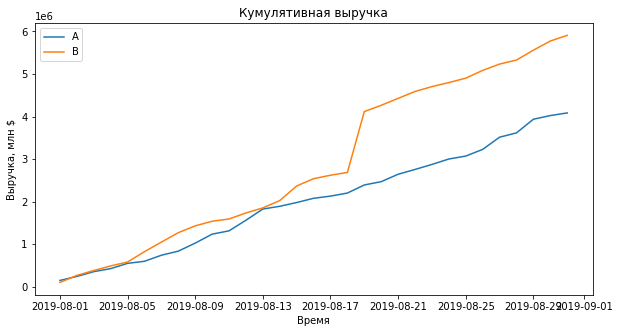

In [7]:
register_matplotlib_converters()

#orders['date'] = orders['date'].map(
#    lambda x: dt.datetime.strptime(x, '%d/%m/%Y')
#)


#visitors['date'] = visitors['date'].map(
#    lambda x: dt.datetime.strptime(x, '%d/%m/%Y')
#)

datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend() 
plt.title('Кумулятивная выручка')
plt.ylabel('Выручка, млн $')
plt.xlabel('Время')
plt.show()

Кумулятивная выручка по группе В находится стабильно выше, чем по группе А. При этом, до какого-то момента графики выручки идут довольно близко, а затем происходит резкий скачок у группы В, что может говорить о налиции аномалий в выборке.

<h3>Кумулятивный средний чек</h3>
Построим график кумулятивного среднего чека по группам:

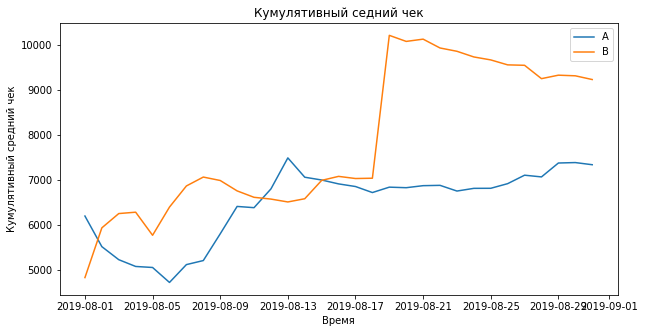

In [8]:
plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('Кумулятивный седний чек')
plt.ylabel('Кумулятивный средний чек')
plt.xlabel('Время')
plt.show()

Кумулятивный средний чек по группе В также в среднем превышает аналогичный для группы А. При этом выброс в районе 18 августа здесь еще более отчетливый, что подтверждает наше предположение о выбросах, которые необходимо определить и отфильтровать.

<h3>Изменение кумулятивного среднего чека</h3>
Построим график относительного изменения кумулятивного среднего чека группы B к группе A:

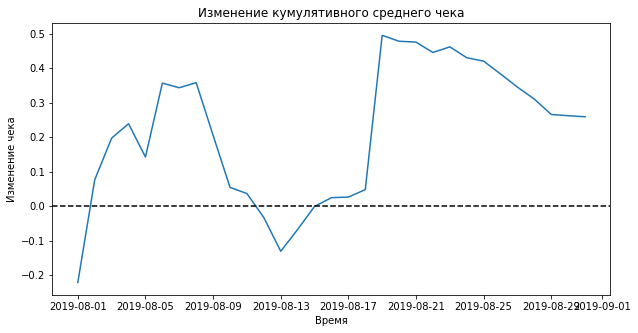

In [9]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Изменение кумулятивного среднего чека')
plt.ylabel('Изменение чека')
plt.xlabel('Время')
plt.show()

Кумулятивное изменение среднего чека имеет резкий провал, вызванный падением чека в группе А, а потом резкий всплеск, который мы отмечали ранеее в группе В. <b>Вероятно, в эти периоды были совершены аномальные заказы.</b> Фактически, <b>изменение кумулятивного чека колеблется, поэтому сложно скзать о какой-то установившейся динамике.</b>

<h3>Кумулятивная конверсия</h3>
Построим график кумулятивной конверсии по группам:

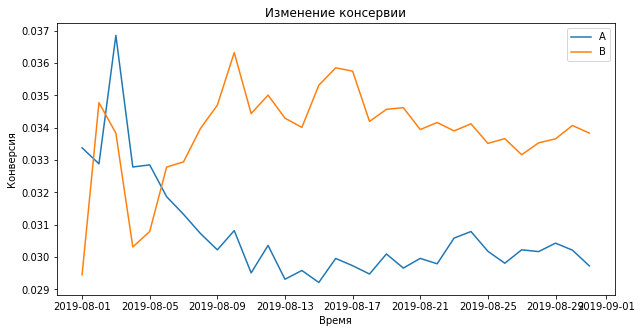

In [10]:
cumulativeData['conversion']=cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(10,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('Изменение консервии')
plt.ylabel('Конверсия')
plt.xlabel('Время')
plt.show()


Непродолжительное время обе конверсии колебались примерно одинаоквым образом, но достаточно быстро разнонаправленно разошлись: конверсия группы А снизилась и продолжила колебаться в районе значения 0,03, конверсия группы В выросла и установилась в области значений 0,034 - 0,035

<h3>Изменение кумулятивной конверсии</h3>
Построим график относительного изменения кумулятивной конверсии группы B к группе A:

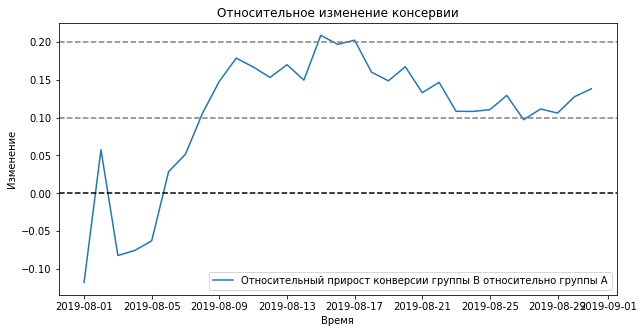

In [11]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.title('Относительное изменение консервии')
plt.ylabel('Изменение')
plt.xlabel('Время')
plt.show()

В подтверждение предыдущего графиука относительное изменение конверсии групппы В относительно группы А демонстрирует рост и устоявшиеся колебания вокруг значения прироста порядка 12% относительно значений группы А.

<h3>Количество заказов по пользователям</h3>
Построим точечный график количества заказов по пользователям:

      visitor_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


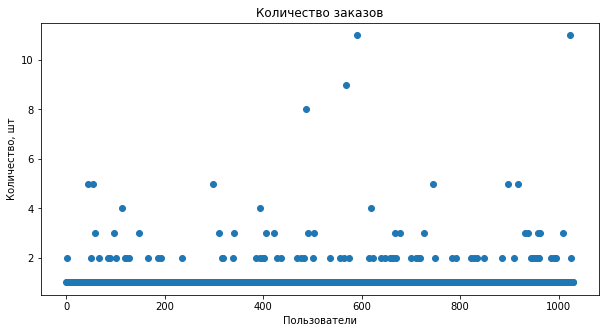

In [12]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(10,5))
plt.scatter(x_values,ordersByUsers['orders'])
plt.title('Количество заказов')
plt.ylabel('Количество, шт')
plt.xlabel('Пользователи')
plt.show()

Подавляющее большинство пользователей совершили всего 1 заказ, значительно меньше, но все же еще большое количество - 2 заказа, 3 и более - единичные случаи, их мы и будем считать выбросами. Проверим наше предположение, посчитав перцентили:

<h3>Расчет перцентилей</h3>
Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей:b

In [13]:
print(np.percentile(ordersByUsers['orders'],[95,99]))

[2. 4.]


Получаем, что только 5% польователей сделали 2 и более заказов, 4 и более заказа - не более 1%. Таким образом, <b>аномальными будут считаться пользователи, совершившие более 2 заказов.</b>

<h3>Стоимость заказов</h3>
Построим точечный график стоимости заказов:

      transaction_id  visitor_id       date  revenue group
425        590470918  1920142716 2019-08-19  1294500     B
1196      3936777065  2108080724 2019-08-15   202740     B
858        192721366  1316129916 2019-08-27    93940     A
1136       666610489  1307669133 2019-08-13    92550     A
744       3668308183   888512513 2019-08-27    86620     B
682       1216533772  4266935830 2019-08-29    78990     B
662       1811671147  4266935830 2019-08-29    78990     A
743       3603576309  4133034833 2019-08-09    67990     A
1103      1348774318  1164614297 2019-08-12    66350     A
1099       316924019   148427295 2019-08-12    65710     A


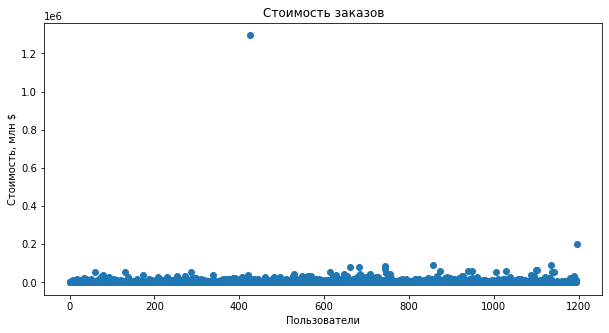

In [14]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(10,5))
plt.scatter(x_values,orders['revenue'])
plt.title('Стоимость заказов')
plt.ylabel('Стоимость, млн $')
plt.xlabel('Пользователи')
plt.show()

Значительно выбивается заказ в 1,3 миллиона. Он, очевидно и служит причиной аномалий в выручке и конверсии. В среднем, выбиваются заказы в районе 200 тысяч и около 100 тысяч. Рассчитаем 95 и 99 перцентили для определния более точной границы аномалий

<h3>Расчет перцентилей</h3>
Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных пользователей:

In [15]:
print(np.percentile(orders['revenue'],[95,99]))

[28000.  58233.2]


Аналогично  количеству заказов, можем отсечь границу аномалии по 95 перцентилю. Принимаем границу в <b>28000.</b>

<h3>Статистическая значимость различий в конверсии между группами по «сырым» данным</h3>
Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным:

Сформулируем нулевую и альтерантивную гипотезы:
<br><b>Нулевая гипотеза Н0</b> - статистически значимые различия конверсии в грппах А и В по "сырым данным" отстутсвуют
<br><b>Альтернативная гипотеза Н1</b> - В средних конверсиях по "сырым данным" есть статистически значимые различия 

In [20]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')


sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print('p-value',"{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительное различие между группами',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

P-value меньше, чем статистическая значимость 0.05, таким образом нулевую гипотезу отвергаем.
<br><b>Сырые данне говорят о том, что в средних конверсиях есть статистически значимые различия. Относительный прирост по срырм данным конверсии группы В к конверсии группы А составляет почти 14%</b>

<h3>Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным</h3>

<br>Сформулируем нулевую и альтерантивную гипотезы:
<br><b>Нулевая гипотеза Н0</b> - статистически значимые различия в среднем чеке заказа между группами А и В по "сырым данным" отстутсвуют
<br><b>Альтернативная гипотеза Н1</b> - В среднем чеке по "сырым данным" есть статистически значимые различия 

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

In [17]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print('p-value','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие между группами','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value 0.729
Относительное различие между группами 0.259


P-value больше 0.05, то есть статистически значимых различий между средними чеками по сырым данным нет. Хотя относительное различе выглядит достаточно большим и составляет 26%. 
<br>Явно требуется очистить данные от аномалий и проанализировать чистые данные.

<h3>Статистическая значимость различий в конверсии между группами по «очищенным» данным</h3>

Сформулируем нулевую и альтерантивную гипотезы:
<br><b>Нулевая гипотеза Н0</b> - статистически значимые различия конверсии в грппах А и В по очищенным данным отстутсвуют
<br><b>Альтернативная гипотеза Н1</b> - В средних конверсиях по очищенным данным есть статистически значимые различия 
Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

In [18]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('p-value','{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное различие между группами','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value 0.01334
Относительное различие между группами 0.172


P-value меньше, чем статистическая значимость 0.05, таким образом нулевую гипотезу отвергаем.
Обработанные и избавленные от аномалий данные также говорят о том, что в средних конверсиях есть статистически значимые различия. Относительный прирост по срырм данным конверсии группы В к конверсии группы А составляет 17%

<h3>Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным</h3>
Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным:

<br>Сформулируем нулевую и альтерантивную гипотезы:
<br><b>Нулевая гипотеза Н0</b> - статистически значимые различия в среднем чеке заказа между группами А и В по очищенным данным отстутсвуют
<br><b>Альтернативная гипотеза Н1</b> - В среднем чеке по очищенным данным есть статистически значимые различия 

In [19]:


print('p-value',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное различие между группами',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value 0.720
Относительное различие между группами -0.023


P-value больше, чем статистическая значимость 0.05, таким образом нулевую гипотезу не отвергаем.
Обработанные и избавленные от аномалий данные говорят, что статистически значимых различий между средними чеками нет. Хотя относительное различие  очень невелико по сравнению с сырыми данными и составляет всего 2,3%.

<h3>Решение по результатам теста</h3>

По сырым и очищенным данным конверсии выборка В явно смотится лучше выборки А, аналогично выглядят и графики конверсии и её относительного изменения. 
<br>Однако, и сырые и обработанные данные по среднему чеку говорят, что статистически значимых различий между данными группами нет. Несмотря на то, что относительное различие между группами после удаления аномалий сократилось с 26% до 2,3%.
График относительного изменения среднего чека также выглядит неустановившимся.
<b>Необходимо продолжить тест с целью сбора большего количества данных.</b>

<h1>Общий вывод</h1>

В ходе исследования были приоритизированы гипотезы с примененеиме фреймворков ICE и RICE. По результатам приоритизации в топ-5 оказались одни и те же гиоптезы ,однако их положение внутри топа изменилось. При переходе от методологии ICE к RICE веред вышли гипотезы,имеющие больший охват, а гипотезы с меньшим охватом - откатились вниз.

В ходе анализа A/B-теста были изучены показатели выручки для групп А и В. Графики по основынм показателям демонстрировали явное наличие аномалий - выбросов по кумулятивной выручке и среднему чеку. С помощью точечных графиков и выделения перцентилей аномалии были определены и впоследствии исключены.
Анализ по сырым данным показал отсутсвие статистически значимых отлиичий по среднему чеку и превосходство группы В над группой А по коневесрии. После очистки данных от аномалий результат остался аналогичным - превосходство В над А по конверсии (что подтверждается графиком изменения конверсии), но отствтие статистически значимых различий по среднему чеку. 
<b>Рекомендовано продолжить тест для сбора большего количества данных</b>